Files needed for this demo:
* tabulated_logE_sindec_aeff_full.pckl
* bckg_flux_vals.pickle
* energy_smearing_kde.pckl
* e_psi_grid.pickle

# Imports

In [161]:
import pickle
import numpy as np
from os.path import join
import warnings
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2
from scipy.interpolate import RegularGridInterpolator
warnings.filterwarnings("ignore")


In [162]:
from matplotlib.colors import LogNorm
import sys
sys.path.insert(1, '/home/ssclafani/pone/software/Plenum/core/')
# set your path here
BASEPATH = "/home/ssclafani/pone/software/Plenum/"

# Source parameters

In [163]:
# livetime of 10yrs in seconds
LIVETIME = 365 * 1 * 86400
# Normalization energy of power law (E/E0)^gamma
E0 = 1E3
# Source flux spectral index
GAMMA =  3.2 2.1
PHI_0 = 5e-14 # neutrinos * (E/E0)^gamma / GeV / cm^2 / s 
#PHI_0 = 2.1e-14 #1/TeVscm^2
# source declination
SRC_DEC = 0 # radian => source at horizon

# analysis region in distance to source
delta_psi = 1

# Functions

In [164]:
def get_mids(bins, ext=False):
    """ Calculate the bin mids from an array of bins """
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext==False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res

In [165]:
def energy_smearing(ematrix, ev):
    """Translate a matrix with axis in true energy to reconstructed energy"""
    return (ematrix @ ev.T).T

In [166]:
def atmo_background(aeff_factor, bckg_flux_vals, normed_kvals):
    """Calculate the number of neutrinos of atmospheric background flux as a function reconstructed energy"""
    return energy_smearing(normed_kvals, aeff_factor * bckg_flux_vals)


In [167]:
def array_source_interp(dec, array, sindec_bins):
    """Take a 2D array and interpolate its values
    based on a value (dec) on the second axis"""

    sindec_mids = get_mids(sindec_bins)
    low_ind = np.digitize(np.sin(dec), sindec_bins) - 1

    if low_ind >= (len(sindec_mids)-1):
        array_interp = array[:, -1]
    elif low_ind == 0:
        array_interp = array[:, low_ind]
    else:
        if sindec_mids[low_ind] > np.sin(dec):
            low_ind -= 1
        array_interp = np.zeros(len(array))
        for i in range(len(array)):
            array_interp[i] = np.interp(
                np.sin(dec),
                [sindec_mids[low_ind], sindec_mids[low_ind + 1]],
                [array[i, low_ind], array[i, low_ind + 1]],
            )
    return array_interp


# Get the effective area

In [168]:
# use only upgoing data to mimick up-going muon track data set
#h2d = np.load('../data/PONE_nu_effa_70_string_eq.npy', allow_pickle=True)[()]
h2d = np.load('/home/ssclafani/pone/data/PONE_nu_effa_70_string_binning.npy', allow_pickle=True)[()]

#h2d = np.load(base_dir + 'pstracks_nu_effa.npy', allow_pickle=True)[()]
logE_bins = h2d.bins[0]
coszen_bins = h2d.bins[1]
aeff_2d = 1e4*h2d.values #values are in m^2 not cm^2 

logE_mids = get_mids(logE_bins)
# cut at E=10⁹GeV
#logE_bins = logE_bins[logE_bins<=9]
#aeff_2d = aeff_2d["IceCube"][logE_mids<=9]
#logE_mids = logE_mids[logE_mids<=9]


ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

coszen_mids = get_mids(coszen_bins)
coszen_width = np.diff(coszen_bins)


print(len(emids), "log_10(energy) bins")
print(len(coszen_mids), "declination bins")


25 log_10(energy) bins
49 declination bins


In [169]:
print(logE_bins)

[2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4 4.6 4.8 5.  5.2 5.4
 5.6 5.8 6.  6.2 6.4 6.6 6.8 7. ]


In [170]:
from aeff_calculations import setup_aeff_grid, aeff_rotation
from settings import poles  # coordinates of a couple of detectors

# this is local azimuth
azi_bins = np.linspace(0, np.pi * 2, num=101)
azi_mids = (azi_bins[1:] + azi_bins[:-1]) * 0.5
azi_width = azi_bins[1:] - azi_bins[:-1]
## cosT_bins_raw = bins in cos(theta) of effective area (usually -1 ... 1)

k = "P-ONE"  # select the right coordinates for P-ONE
# setup evaluation grids
grid2d, eq_coords = setup_aeff_grid(
    aeff_2d,  # make sure eff-area has the matching axes in cos(t) and azimuth
    get_mids(coszen_bins),
    azi_mids,
    azi_width,
)

aeff_eq = (
    aeff_rotation(
        poles[k]["lat"],  # coordinates of P-ONE: latitude
        poles[k]["lon"],  # coordinates of P-ONE: longitude
        eq_coords,
        grid2d,
        azi_width,
    )
    #* 1e4
)  # m^2 -> cm^2, depends if you need this translation to cm^2 or not

In [171]:
sindec_bins = coszen_bins[::-1]
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

(2.0, 7.0)

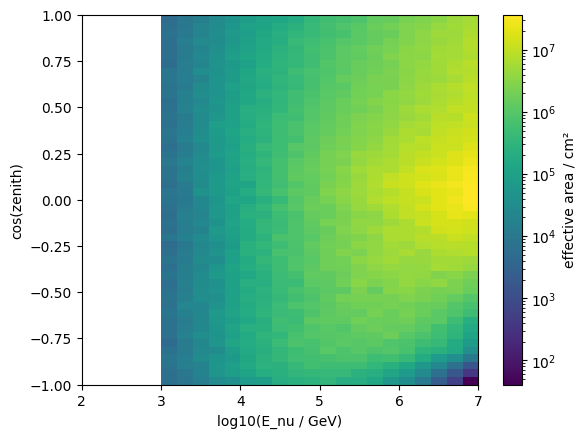

In [172]:
plt.pcolormesh(logE_bins, coszen_bins, aeff_2d.T, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("cos(zenith)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 7)

(2.0, 7.0)

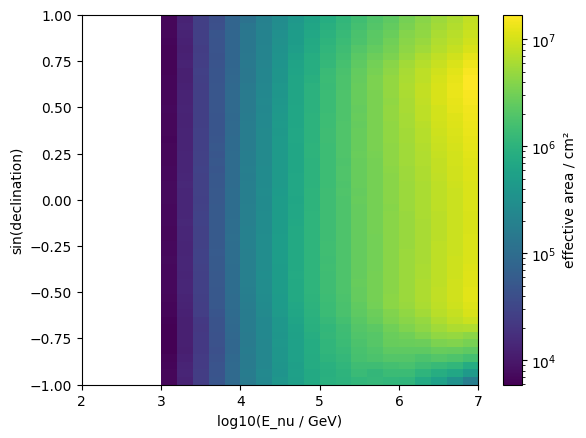

In [173]:
plt.pcolormesh(logE_bins, sindec_bins, aeff_eq.T, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 7)

# Background

In [174]:
# MCEQ
with open("/home/ssclafani/pone/software/Plenum/resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_total"])
)
# baseline evaluation
ss, em = np.meshgrid(sindec_mids, emids)
bckg_flux_vals = np.exp(rgi((em, ss))).T

(2.0, 7.0)

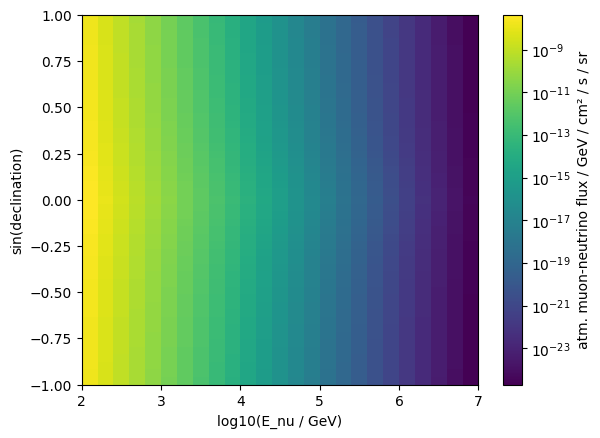

In [175]:
plt.pcolormesh(logE_bins, sindec_bins, bckg_flux_vals, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 7)

# Energy smearing

In [176]:
import scipy

In [177]:
scipy.interpolate.RegularGridInterpolator

scipy.interpolate._rgi.RegularGridInterpolator

In [178]:
'''# energy smearing matrix as an interpolation function
with open("/home/ssclafani/pone/software/Plenum/resources/energy_smearing_rgi.pckl", "rb") as f:
    kde, _logE_bins, _logE_reco_bins = pickle.load(f)
#E_grid = np.load("/home/ssclafani/pone/software/Plenum/resources/energy_smearing_kde.pckl", allow_pickle=True)    

# construct an interpolator to match the aeff binning
#rgi = RegularGridInterpolator((get_mids(_logE_reco_bins), get_mids(_logE_bins)), normed_kvals)

# new binning
logE_reco_bins = np.arange(1.9, 9.02, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)

# logE_mids is from the effective area binning
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)

# baseline evaluation of the interpolation function 'rgi'
normed_kvals = kde((lre_grid, lge_grid))

# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)'''

'# energy smearing matrix as an interpolation function\nwith open("/home/ssclafani/pone/software/Plenum/resources/energy_smearing_rgi.pckl", "rb") as f:\n    kde, _logE_bins, _logE_reco_bins = pickle.load(f)\n#E_grid = np.load("/home/ssclafani/pone/software/Plenum/resources/energy_smearing_kde.pckl", allow_pickle=True)    \n\n# construct an interpolator to match the aeff binning\n#rgi = RegularGridInterpolator((get_mids(_logE_reco_bins), get_mids(_logE_bins)), normed_kvals)\n\n# new binning\nlogE_reco_bins = np.arange(1.9, 9.02, step=0.05)\nlogE_reco_mids = get_mids(logE_reco_bins)\n\n# logE_mids is from the effective area binning\nlge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)\n\n# baseline evaluation of the interpolation function \'rgi\'\nnormed_kvals = kde((lre_grid, lge_grid))\n\n# normalize per bin in true energy\nnormed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)'

In [179]:
normed_kvals, logE_reco_bins, logE_bins = np.load(
    '/home/ssclafani/pone/software/Plenum/resources/energy_smearing.npy',
                                                  allow_pickle=True)

In [180]:
rgi = RegularGridInterpolator((get_mids(logE_reco_bins), get_mids(logE_bins)), normed_kvals)

logE_reco_bins = np.arange(1.9, 9.02, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)

# logE_mids is from the effective area binning
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)

# baseline evaluation of the interpolation function 'rgi'
normed_kvals = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)

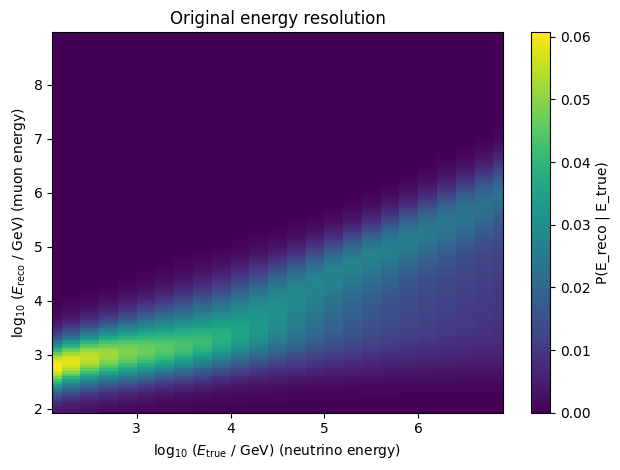

In [181]:
# logE_mids are the same as for effective area binning
egrid_true, egrid_reco = np.meshgrid(logE_mids, logE_reco_mids)

f, axes = plt.subplots()

axes.grid(False)
im = axes.pcolormesh(egrid_true, egrid_reco, normed_kvals)
axes.set_ylim(np.min(egrid_reco), np.max(egrid_reco))
axes.set_xlim(np.min(egrid_true), np.max(egrid_true))
axes.set_title("Original energy resolution")
axes.set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes.set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")
cb = f.colorbar(im)
cb.set_label("P(E_reco | E_true)")
f.tight_layout()

# Source flux definition

In [182]:
def astro_flux(
    aeff_factor,
    emids,
    E0,
    gamma,
    phi_scaling,
    PHI_0=PHI_0
):
    """
    flux shape: dphi/dE = phi_0 * (E/E0) ** -gamma
    powerlaw parameters:
        * gamma
        * phi scaling (phi normalization will be phi_0 * phi scaling) 
          -> actual fit parameter will be of magnitude 1 instead of E-14
    """
    tmp = aeff_factor * (emids/E0)**(-gamma) * PHI_0 * phi_scaling
    return energy_smearing(normed_kvals, tmp)
    #return tmp

# calculate number of events per source as crosscheck

(should be 39.6 events in total)

In [183]:
aeff_factor_signal = (
    array_source_interp(SRC_DEC, aeff_eq, sindec_bins) * LIVETIME * ewidth
)
# this is only 1D in energy dimension
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    E0,
    GAMMA,
    1,
)
print(np.sum(k_s))


9.215558126814534


# Psi-Energy histogram

Going 2D now with angular distance 'Psi'

In [184]:
len(logE_mids)

25

In [185]:
with open(join(BASEPATH, "resources/e_psi_grid.pickle"), "rb") as f:
    # 2D histogram in log(E) and psi²
    e_psi2_grid = pickle.load(f)

In [186]:
len(np.sum(e_psi2_grid, axis=0))

40

In [187]:
e_psi2_grid = e_psi2_grid[:, :len(logE_mids)]

In [188]:
'''with open(join(BASEPATH, "resources/e_psi_grid.pickle"), "rb") as f:
    # 2D histogram in log(E) and psi²
    e_psi2_grid = pickle.load(f)
# cut to right size in energy
'''
e_psi_h = np.load('../data/dpsi2_vs_logenergy_1deg.npy', allow_pickle=True)[()]
#e_psi2_grid = e_psi_h.values.T[:, :len(logE_mids)]

#e_psi2_grid = e_psi2_grid[:, :len(logE_mids)]
#e_psi2_grid = e_psi_h.values.T

In [189]:
'''e_psi_h_linear = np.load('../data/dpsi_vs_logenergy_1deg.npy', allow_pickle=True)[()]
e_psi2_grid_linear = e_psi_h_linear.values.T
plt.pcolormesh(get_mids(e_psi_h_linear.bins[0]), get_mids(e_psi_h_linear.bins[1]), e_psi_h_linear.values.T)
plt.ylabel("(Psi/deg)")
plt.xlabel("loag10(E_reco/GeV)")
plt.title("Signal point-source flux")'''

'e_psi_h_linear = np.load(\'../data/dpsi_vs_logenergy_1deg.npy\', allow_pickle=True)[()]\ne_psi2_grid_linear = e_psi_h_linear.values.T\nplt.pcolormesh(get_mids(e_psi_h_linear.bins[0]), get_mids(e_psi_h_linear.bins[1]), e_psi_h_linear.values.T)\nplt.ylabel("(Psi/deg)")\nplt.xlabel("loag10(E_reco/GeV)")\nplt.title("Signal point-source flux")'

In [190]:
e_psi2_grid = e_psi_h.values.T

Text(0.5, 1.0, 'Signal point-source flux')

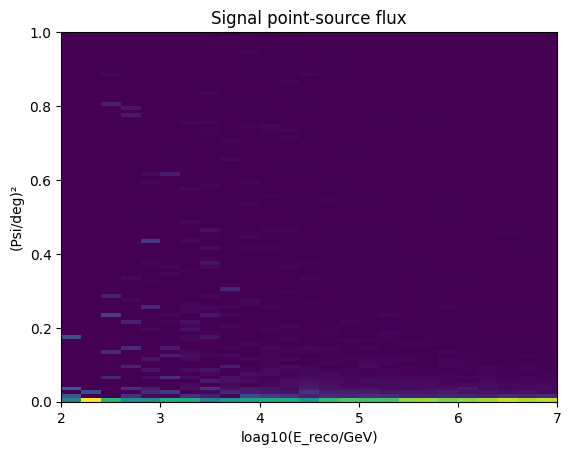

In [191]:
plt.pcolormesh(get_mids(e_psi_h.bins[0]), get_mids(e_psi_h.bins[1]), e_psi_h.values.T)
plt.ylabel("(Psi/deg)²")
plt.xlabel("loag10(E_reco/GeV)")
plt.title("Signal point-source flux")

In [192]:
e_psi2_grid.shape

(100, 25)

In [193]:
# Background is uniform in psi²
# so we generate a matching uniform histogram here
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)


In [194]:
'''bckg_grid_linear = np.ones_like(e_psi2_grid_linear)
bckg_grid_linear /= np.sum(bckg_grid_linear, axis=0)'''

'bckg_grid_linear = np.ones_like(e_psi2_grid_linear)\nbckg_grid_linear /= np.sum(bckg_grid_linear, axis=0)'

### Full nominal (=Asimov) histograms in Psi - log(E)

Fit parameters for analysis:
* Global normalization of k_b
* Global normalization of k_s
* Spectral index of k_s (=gamma)

In [195]:
aeff_factor_bckg = (
    (
        array_source_interp(SRC_DEC, aeff_eq, sindec_bins)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    * bckg_grid #_linear
    * 1
)  ## nominal value, FIT PARAMETER

aeff_factor_signal = (
    array_source_interp(SRC_DEC, aeff_eq, sindec_bins) * LIVETIME * ewidth * e_psi2_grid #_linear
)
# model expectation before adding fit parameters
mu_b_base = deepcopy(aeff_factor_bckg)
mu_s_base = deepcopy(aeff_factor_signal)

# asimov data
k_b = atmo_background(
    aeff_factor_bckg,
    array_source_interp(SRC_DEC, bckg_flux_vals.T, sindec_bins).T,
    normed_kvals,
)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    E0,
    GAMMA,  ## FIT PARAMETER
    1,  ## FIT PARAMETER
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))  # ~550
print("Signal:", np.sum(k_s))  # ~40
print("S+B", np.sum(k_i))  # ~590


Asimov data sum:
Background: 14.488486988619805
Signal: 9.215558126814532
S+B 23.704045115434337


## some plotting

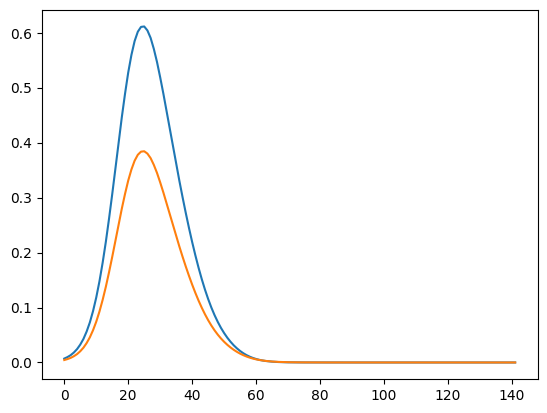

In [196]:
plt.plot(np.sum(k_b, axis=0))
plt.plot(np.sum(k_s, axis=0))

In [197]:
#delta_psi = .1
psi2_bins = np.linspace(0, delta_psi**2, 101)
psi_bins = np.linspace(0, delta_psi, 101)

In [198]:
psi2_bins

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [199]:
k_s.shape

(100, 142)

Text(0.5, 1.0, 'Signal point-source flux')

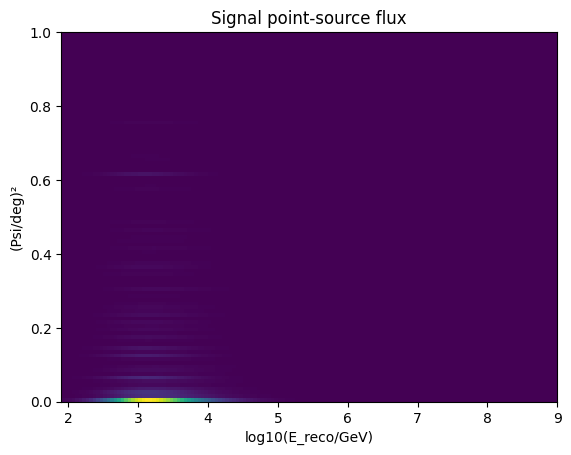

In [200]:
plt.pcolormesh(logE_reco_bins, psi2_bins, k_s)
plt.ylabel("(Psi/deg)²")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Signal point-source flux")

Text(0.5, 1.0, 'Signal point-source flux')

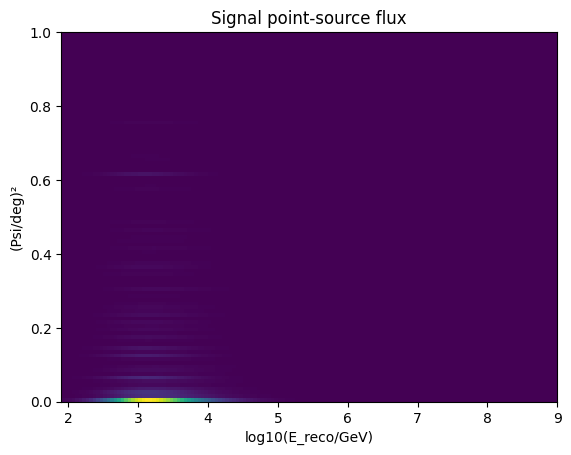

In [201]:
plt.pcolormesh(logE_reco_bins, psi_bins, k_s)
plt.ylabel("(Psi/deg)²")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Signal point-source flux")

Text(0.5, 1.0, 'Background atmospheric flux')

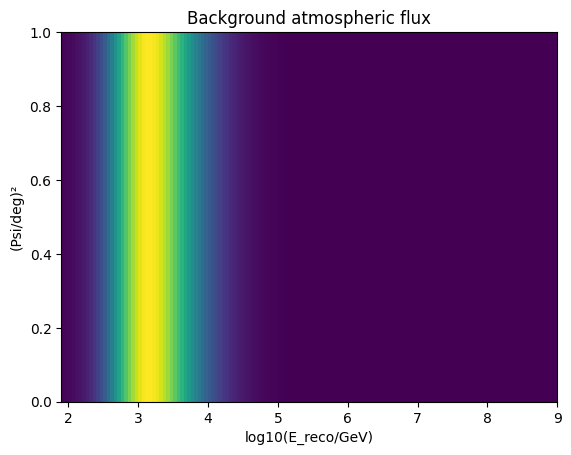

In [202]:
plt.pcolormesh(logE_reco_bins, psi2_bins, k_b)
plt.ylabel("(Psi/deg)²")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Background atmospheric flux")

In [222]:
np.sum(k_b)

14.488486988619805

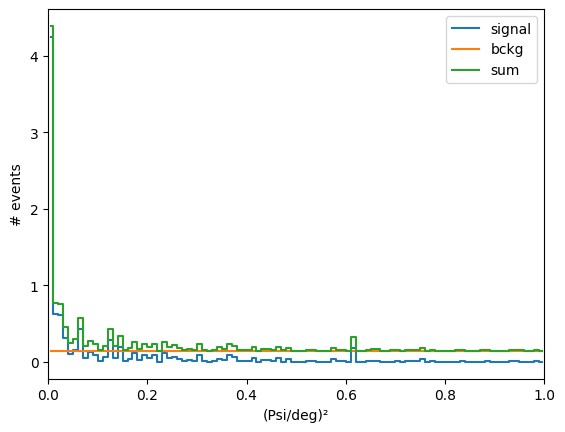

In [203]:
# summed 1D hist in psi²
plt.plot(get_mids(psi2_bins), k_s.sum(axis=1), ds="steps-mid", label="signal")
plt.plot(get_mids(psi2_bins), k_b.sum(axis=1), ds="steps-mid", label="bckg")
plt.plot(get_mids(psi2_bins), k_i.sum(axis=1), ds="steps-mid", label="sum")
#plt.ylim(0, 14)
plt.xlim(0, 1)
plt.xlabel("(Psi/deg)²")
plt.ylabel("# events")
plt.legend()

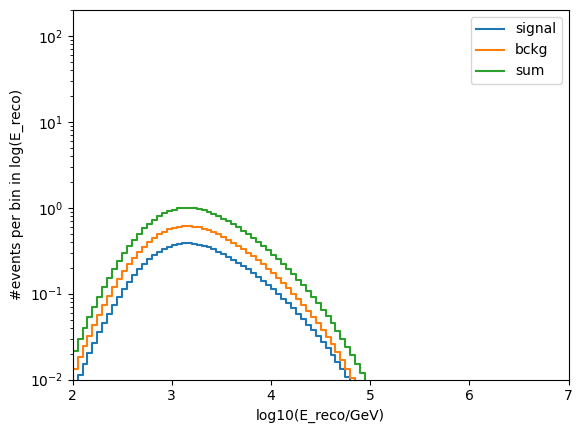

In [204]:
plt.plot(logE_reco_mids, k_s.sum(axis=0), ds="steps-mid", label="signal")
plt.plot(logE_reco_mids, k_b.sum(axis=0), ds="steps-mid", label="bckg")
plt.plot(logE_reco_mids, k_i.sum(axis=0), ds="steps-mid", label="sum")
plt.yscale("log")
plt.xlim(2, 7)
plt.ylim(1E-2, 2E2)
plt.ylabel("#events per bin in log(E_reco)")
plt.xlabel("log10(E_reco/GeV)")
plt.legend()

### DEMO: Significance test Background vs. Background + Signal

In [205]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0=E0,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    """

    mu_b = atmo_background(
        mu_b_base * x[0],
        array_source_interp(SRC_DEC, bckg_flux_vals.T, sindec_bins).T,
        normed_kvals,
    )
    mu_s = astro_flux(mu_s_base, emids, e_0, *x[1:])
    mu_i = mu_s + mu_b
    # -2 Log Likelihood (B/S)
    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


In [206]:
from scipy.optimize import minimize


In [207]:
# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: ps_llh_2d_composite(
    (x[0], 2, 0), mu_b_base, mu_s_base, k_i
)
# background + signal, 3 free parameters
global_llh = lambda x: ps_llh_2d_composite(
    x, mu_b_base, mu_s_base, k_i
)
# ... and fit both hypotheses!
out_bckg = minimize(
    local_llh,
    x0=(0.8,),
    #approx_grad=True,
)
#print("Bckg-only normalization:", out_bckg[0])
print(out_bckg['fun'])
print('Function Calls: {}'.format(out_bckg['nfev']))

#print(out_bckg)
print("Bckg-only normalization:", out_bckg['x'])
out_comp = minimize(
    global_llh,
    x0=(1.2, 3.0, 1.2),
    #approx_grad=True,
)
#print("Signal fit parameters:", out_comp[0])
print('Function Calls: {}'.format(out_comp['nfev']))
print(out_comp['fun'])
print("Signal fit parameters:", out_comp['x'])
# calculate p-value and significance with Wilks' and 2 d.o.f
pval = chi2.sf(out_bckg['fun'] - out_comp['fun'], 2)

significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE: {}".format(pval), "SIGNIFICANCE: {:.5f}".format(significance))


-205580.36565772435
Function Calls: 18
Bckg-only normalization: [1.63608727]
Function Calls: 56
-205602.38846941537
Signal fit parameters: [1.00001455 3.19987089 0.99984536]
P-VALUE: 1.6512286042457926e-05 SIGNIFICANCE: 4.30748


In [208]:
def get_pval(src, verbose=False):
    # livetime of 10yrs in seconds
    LIVETIME = src['lt']
    # Normalization energy of power law (E/E0)^gamma
    E0 = src['E0']
    # Source flux spectral index
    GAMMA = src['gamma']
    PHI_0 = src['PHI_0'] 
    SRC_DEC = src['dec']# radian => source at horizon

    # analysis region in distance to source
    delta_psi = 1
    aeff_factor_bckg = (
        (
            array_source_interp(SRC_DEC, aeff_eq, sindec_bins)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        )
        * bckg_grid #_linear
        * 1
    )  ## nominal value, FIT PARAMETER

    aeff_factor_signal = (
        array_source_interp(SRC_DEC, aeff_eq, sindec_bins) * LIVETIME * ewidth * e_psi2_grid #_linear
    )
    # model expectation before adding fit parameters
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(SRC_DEC, bckg_flux_vals.T, sindec_bins).T,
        normed_kvals,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        E0,
        GAMMA,  ## FIT PARAMETER
        1,  ## FIT PARAMETER
        PHI_0
    )
    k_i = k_s + k_b

    #print("Asimov data sum:")
    if verbose:
        print("Background: {:.2f}".format(np.sum(k_b)))  # ~550
        print("Signal: {:.2f}".format(np.sum(k_s)))  # ~40
    #print("S+B", np.sum(k_i))  # ~590
    # define the fitting functions with all parameters
    # background only, 1 free parameter
    local_llh = lambda x: ps_llh_2d_composite(
        (x[0], 2, 0), mu_b_base, mu_s_base, k_i
    )
    # background + signal, 3 free parameters
    global_llh = lambda x: ps_llh_2d_composite(
        x, mu_b_base, mu_s_base, k_i
    )
    # ... and fit both hypotheses!
    out_bckg = minimize(
        local_llh,
        x0=(0.8,),
        #approx_grad=True,
    )
    #print("Bckg-only normalization:", out_bckg[0])
    #print(out_bckg['fun'])
    #print('Function Calls: {}'.format(out_bckg['nfev']))

    #print(out_bckg)
    #print("Bckg-only normalization:", out_bckg['x'])
    out_comp = minimize(
        global_llh,
        x0=(1.2, 3.0, 1.2),
        #approx_grad=True,
    )
    #print("Signal fit parameters:", out_comp[0])
    #print('Function Calls: {}'.format(out_comp['nfev']))
    #print(out_comp['fun'])
    #print("Signal fit parameters:", out_comp['x'])
    # calculate p-value and significance with Wilks' and 2 d.o.f
    pval = chi2.sf(out_bckg['fun'] - out_comp['fun'], 2)

    significance = erfinv(1 - pval) * np.sqrt(2)
    if verbose:
        print("P-VALUE: {}".format(pval), "SIGNIFICANCE: {:.5f}".format(significance))
    return pval, significance

In [209]:
src = {}
src['lt'] = 365 * 1 * 86400
src['E0'] = 1E3
src['gamma'] = 3.2 #2.1
src['PHI_0'] = 5e-14 
src['dec'] = 0 

In [210]:
pval, sig = get_pval(src)

In [211]:
sigs = []
for years in (np.linspace(0,10,50)):
    src['lt'] = 365 * years * 86400
    pval, sig = get_pval(src)
    sigs.append(sig)

Text(0.5, 1.0, 'NGC-1068')

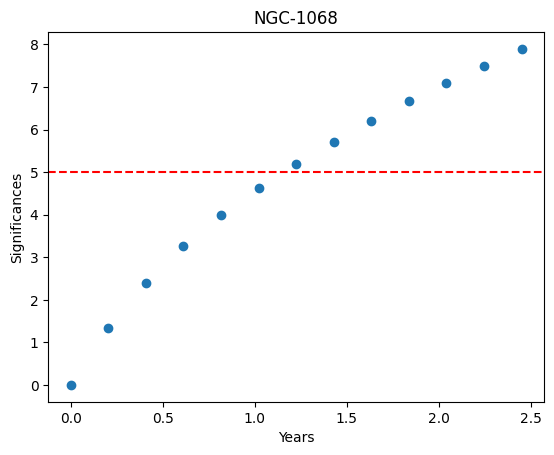

In [218]:
plt.scatter(np.linspace(0,10,50), sigs)
plt.xlabel('Years')
plt.ylabel('Significances')
plt.axhline(5, c='r', ls='--')
plt.title('NGC-1068')

In [213]:
src = {}
src['lt'] = 365 * 1 * 86400
src['E0'] = 1e3
src['gamma'] = 2.1 #2.1
src['PHI_0'] = 2.1e-14 
src['dec'] = 5 

In [214]:
sigs = []
for years in (np.linspace(0,1,50)):
    src['lt'] = 365 * years * 86400
    pval, sig = get_pval(src, verbose=False)
    sigs.append(sig)

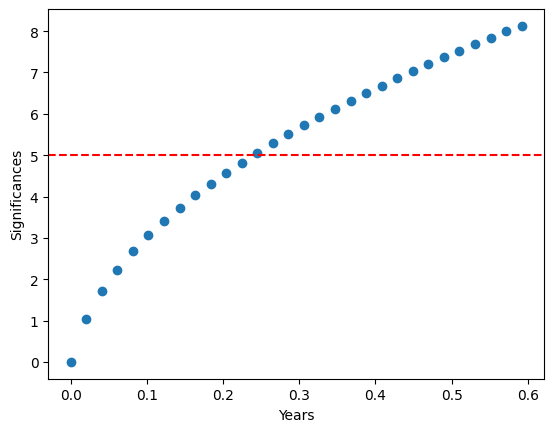

In [215]:
plt.scatter(np.linspace(0,1,50), sigs)
plt.xlabel('Years')
plt.ylabel('Significances')
plt.axhline(5, c='r', ls='--')

In [216]:
sigs = []
norms = np.linspace(0,5,50)
for norm in norms:
    src['lt'] = 365 * 1 * 86400
    src['PHI_0'] = norm * 1e-14
    #print(src['PHI_0'])
    pval, sig = get_pval(src, verbose=False)
    sigs.append(sig)

[]

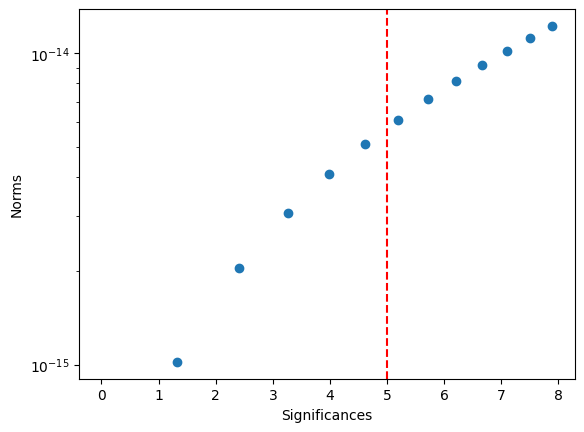

In [217]:
plt.scatter(sigs, norms * 1e-14)
plt.ylabel('Norms')
plt.xlabel('Significances')
plt.axvline(5, c='r', ls='--')
plt.semilogy()